## Assignments (part 2)


###  2. House prices model

In this exercise, you'll work on your house prices model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Run your house prices model again and assess the goodness of fit of your model using F-test, R-squared, adjusted R-squared, AIC and BIC.
* Do you think your model is satisfactory? If so, why?
* In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables. 
* For each model you try, get the goodness of fit metrics and compare your models with each other. Which model is the best and why?





### Load the dataset from the Thinkful PostgreSQL database. 


In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

### Investigate the data, and do any necessary data cleaning

In [104]:
houses_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Based on visualizations above, I'll select categorical variables for the model**


In [105]:
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.street, prefix="street", drop_first=True)], axis=1)



dummy_column_names = list(pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_df.street, prefix="street", drop_first=True).columns)

new_houses = houses_df[['saleprice','overallqual','grlivarea', 'garagecars', 'garagearea','totalbsmtsf','yearbuilt','fullbath','neighborhood','exterqual'] + dummy_column_names]


In [106]:
new_houses = houses_df[['saleprice','overallqual','grlivarea', 'garagecars', 'garagearea','totalbsmtsf','yearbuilt','fullbath','neighborhood','exterqual'] + dummy_column_names]

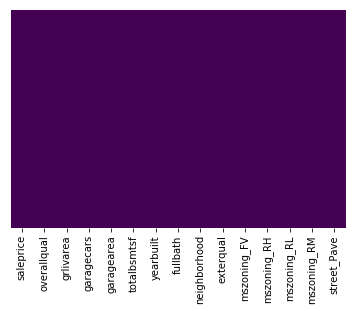

In [107]:
#Verifying if there are some missing values

nonclean = ((new_houses.isnull().sum()*100)/houses_df.saleprice.count())

for value,index in zip(nonclean,nonclean.index):
    if value > 0:
        print('Column: {} with {}% of null values'.format(index,value))


#Cleaning garageyrblt by replacing missing values in a column with a value from yearremodadd because they are high correlated.

sns.heatmap(new_houses.isnull(),yticklabels=False,cbar=False,cmap='viridis')



### Build Regression Model using these features and estimate the parameters using OLS

In [108]:
#Creating feature set for X
    
featureset = [['overallqual','grlivarea','garagecars','totalbsmtsf','mszoning_FV','mszoning_RL'] + dummy_column_names]

X = new_houses[['overallqual','grlivarea','garagecars','totalbsmtsf','mszoning_FV','mszoning_RL'] + dummy_column_names]


# Y is the target variable
Y = new_houses['saleprice']


# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()



#### Run your house prices model again and assess the goodness of fit of your model using F-test, R-squared, adjusted R-squared, AIC and BIC


In [109]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     534.7
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:17:10   Log-Likelihood:                -17476.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1450   BIC:                         3.502e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.15e+05    1.8e+04     -6.389      

R-squared:                       0.768

Adj. R-squared:                  0.767

**This means that our model explains 76.8% of the variance in the charges, leaving 23.2% unexplained**

F-statistic:                     803.3

P-value (F-statistic):           0.00

**Based on p-value of F-statistitc, we can say that our model is useful and contributes something that is statistically significant in the explanation of the target**

AIC:                         3.497e+04

BIC:                         3.500e+04

**AIC and BIC are very high numbers, I should compare with other models**


#### Do you think your model is satisfactory? If so, why?

_It's satisfactory, I like the numbers of R-squared and Adj R-Square. I consider there are some things to improve_

#### In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables

In [110]:
#Adding two categorical variables: centralair and kitchenqual

houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.centralair, prefix="centralair", drop_first=True)], axis=1)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_df.centralair, prefix="centralair", drop_first=True).columns)

houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.kitchenqual, prefix="kitchenqual", drop_first=True)], axis=1)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_df.kitchenqual, prefix="kitchenqual", drop_first=True).columns)


new_houses = houses_df[['poolarea','fullbath','totrmsabvgrd','saleprice','fireplaces','overallqual','grlivarea', 'garagecars', 'garagearea','totalbsmtsf','yearbuilt','fullbath','neighborhood'] + dummy_column_names]

#Creating feature set for X
X = new_houses[['overallqual','grlivarea','garagecars','totalbsmtsf','mszoning_FV','mszoning_RL','fireplaces'] + dummy_column_names]


# Y is the target variable
Y = new_houses['saleprice']


# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())


#houses_df[dummy_column_names]

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     404.0
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:17:16   Log-Likelihood:                -17382.
No. Observations:                1460   AIC:                         3.479e+04
Df Residuals:                    1445   BIC:                         3.487e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -1.97e+04   1.87e+04     -1.

In [111]:
#Adding two more categorical variables: heating and condition2


houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.condition2, prefix="condition2", drop_first=False)], axis=1)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_df.condition2, prefix="condition2", drop_first=True).columns)

houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.heating, prefix="heating", drop_first=False)], axis=1)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_df.heating, prefix="heating", drop_first=True).columns)



new_houses = houses_df[['poolarea','fullbath','totrmsabvgrd','saleprice','fireplaces','overallqual','grlivarea', 'garagecars', 'garagearea','totalbsmtsf','yearbuilt','fullbath','neighborhood'] + dummy_column_names]

#Creating feature set for X
X = new_houses[['overallqual','grlivarea','garagecars','totalbsmtsf','mszoning_FV','mszoning_RL','fireplaces'] + dummy_column_names]


# Y is the target variable
Y = new_houses['saleprice']


# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())



                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     225.5
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:17:18   Log-Likelihood:                -17356.
No. Observations:                1460   AIC:                         3.477e+04
Df Residuals:                    1433   BIC:                         3.491e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7593.8457   4.72e+04  

#### For each model you try, get the goodness of fit metrics and compare your models with each other. Which model is the best and why?

The third one is the best because:

- R-squared and R-squared represent are 0.80 (greater than the other two models). It means our model explains 80.4% of the variance in the charges.

- p-value of F-statistics test is equal to zero 

- AIC and BIC values are lower values than the values from other two models

-------------------------------------------------
By: Wendy Navarrete

8/13/2019